In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import detect_cas

/sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL.Image as Image

base = '/sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/photos'

image = Image.open(os.path.join(base, 'solidbg/canisters/000_all.png'))

possible_labels = [
    'shampoo bottle',
    'air freshener',
    'paint can',
    'cleaning spray',
]

In [4]:
import time
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import PIL.Image as Image
import torch
import torchvision.ops as ops
from transformers import Owlv2ForObjectDetection, Owlv2Processor

device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

# model_name = 'google/owlv2-large-patch14-ensemble'
processor = detect_cas.processor
model = detect_cas.model

In [6]:
def detect(image, label, threshold=0.1):
    with torch.no_grad():
        if type(label) is str:
            labels = ["an image of " + label.lower()]
        else:
            labels = [("an image of " + label_.lower()) for label_ in label]
            
        inputs = processor(text=labels, images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.size[::-1]])
    # Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=threshold)
    results = results[0]
    boxes, scores, labels = results["boxes"], results["scores"], results["labels"]
    
    # Fix heights.
    # boxes[:, 1] *= (image.width / image.height)
    # boxes[:, 3] *= (image.width / image.height)

    keep = {int(i) for i in ops.nms(boxes, scores, iou_threshold=0.2)}
    
    # do not accept boxes that fill a whole quadrant of space
    box_sizes = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) / (image.height * image.width)
    keep = torch.tensor([i for i in keep if box_sizes[i] < 0.25])

    return (boxes[keep], scores[keep], labels[keep], outputs)


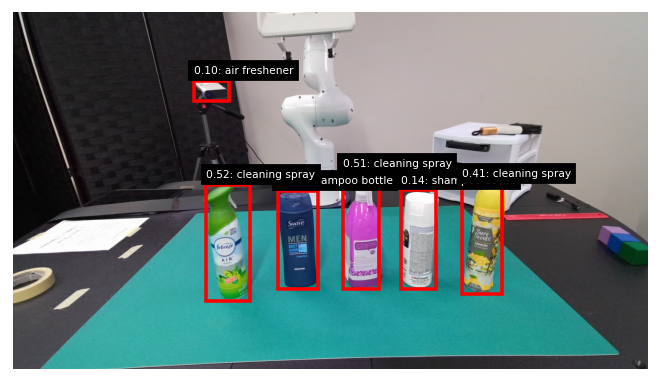

In [7]:
(boxes, scores, labels, outputs) = detect(image, possible_labels, threshold=0.1)

fig = plt.figure(dpi=128)
ax = fig.add_subplot(111)
ax.imshow(image)

for i, (x1, y1, x2, y2) in enumerate(boxes.cpu().numpy()):
    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor='r', linewidth=2
    ))
    
    text_x = x1
    text_y = max(y1 - 15, 10)

    if (x1 / image.width) > 0.9:
        text_x = x2
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'left'
        
    label = possible_labels[labels[i].item()]

    ax.text(
        text_x, text_y, f"{scores[i]:.2f}: {label}", c='white',
        backgroundcolor=(0, 0, 0, 1.0),
        horizontalalignment=horizontalalignment,
        size=6,
    )

plt.axis('off')
plt.show()


## Ranking Solely by Objectness

This is a form of class-agnostic object detection.

In [8]:
outputs.pred_boxes.shape

torch.Size([1, 5184, 4])

29


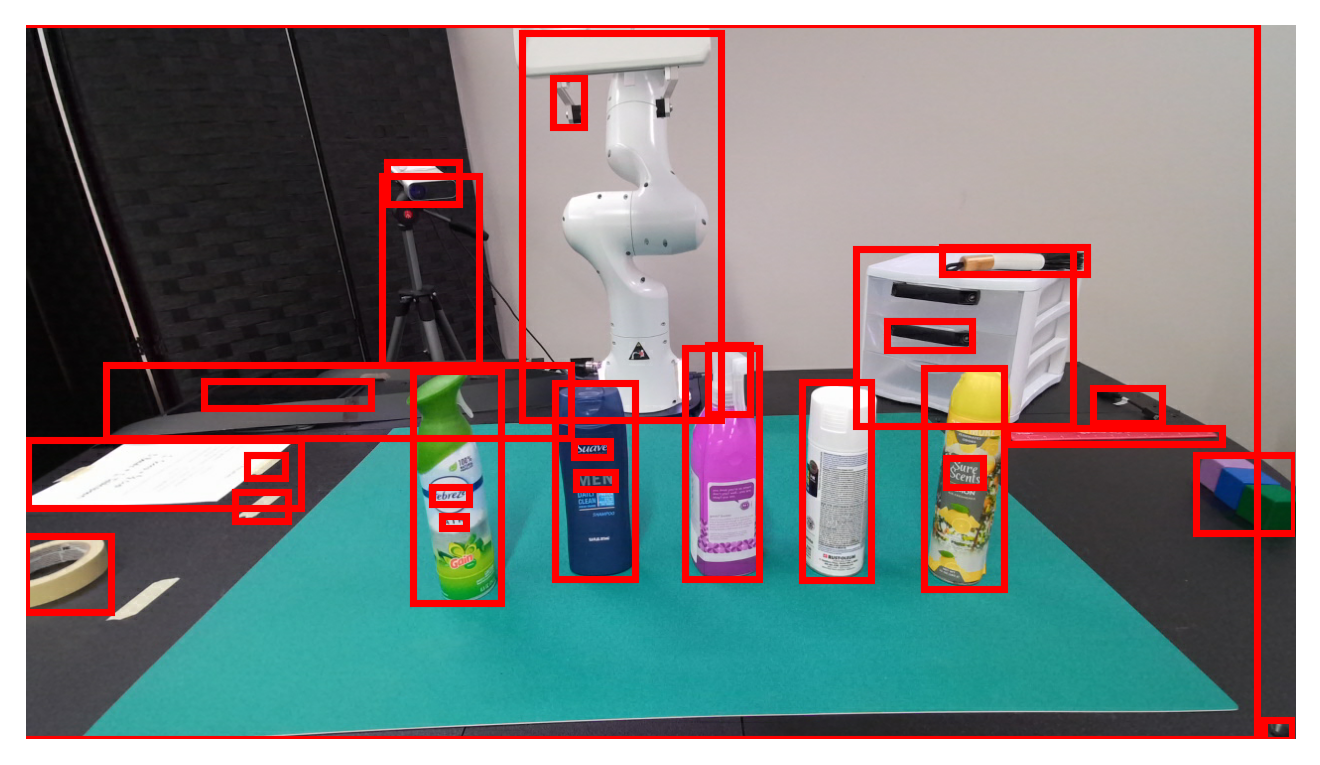

In [22]:
from transformers.image_transforms import center_to_corners_format

pred_boxes = outputs.pred_boxes[0]
objectness_logits = outputs.objectness_logits[0]

# Find the top K objects
topK = 50
best_box_tokens = torch.argsort(objectness_logits, descending=True)[:topK]
best_boxes = pred_boxes[best_box_tokens]
boxes = center_to_corners_format(best_boxes)

scores = torch.sigmoid(objectness_logits[best_box_tokens])

# Do non-maximum suppression
keep_i = ops.nms(boxes, scores, iou_threshold=0.2)
boxes = boxes[keep_i]

boxes[:, [0, 2]] *= image.width
boxes[:, [1, 3]] *= image.width
boxes = boxes.detach().cpu().numpy()

print(len(boxes))

fig = plt.figure(dpi=256)
ax = fig.add_subplot(111)
ax.imshow(image)

for i, (x1, y1, x2, y2) in enumerate(boxes):
    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor='r', linewidth=2
    ))

plt.axis('off')
plt.show()


In [60]:
import detect_cas

In [30]:
dets = detect_cas.detect(image, possible_labels, verbose=True)

Generated coarse detections.
OwlV2 detection time: 0.81
Caption generation time: 2.69


In [31]:
captions, crops, coarse_detection_outputs = dets
captions

['The image features a green and white bottle of Febreze Air spray standing upright on a blue surface. The bottle has a green cap and a white label with a blue circle and green leaf design. The label displays the text " Febreze Air Original" and "100% Natural". The bottle appears to be in good condition and is placed at the center of the frame.',
 'The image features a purple spray bottle with a white cap, standing upright on a green surface. The spray bottle has a white label with purple text, which appears to be a product description or instructions. The spray bottle is the main focus of the image, with the green surface providing a contrasting background.',
 'The image features a close-up view of a yellow and gray Sure Scent spray can standing upright on a green surface. The spray can is labeled "Lemon" and has a 25% more scent than the original product. The spray can is positioned in the center of the frame, with the green surface providing a contrasting background.',
 'The image f

In [32]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

phi2 = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True, device_map=device)
phi2_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

phi2 = torch.compile(phi2, backend='eager')


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [61]:
# Generate a short prompt.
make_prompt = lambda caption, target: f"Question: {caption}\nIs this a {target}? Answer:"
yes_token, no_token = phi2_tokenizer([" Yes", " No"], return_tensors='pt').to(device).input_ids[:, 0]

def get_caption_logits(caption, target):
    prompt = make_prompt(caption, target)
    model_input = phi2_tokenizer(prompt, return_tensors='pt').to(device)
    with torch.no_grad():
        pred = phi2(**model_input)
        
    yn = pred.logits[0, -1, [yes_token, no_token]]
    y, n = yn - yn.min()
    
    return (y.item(), n.item())


In [66]:
import numpy as np

for caption in captions:
    # get the next token prediction
    for possible_label in possible_labels:
        yes_logit, no_logit = get_caption_logits(caption, possible_label)
        score = np.exp(yes_logit) / (np.exp(yes_logit) + np.exp(no_logit))

        print("Caption:", caption)
        print("Label:", possible_label)
        print(f"Score: {score:.2f}")
        print()


Caption: The image features a green and white bottle of Febreze Air spray standing upright on a blue surface. The bottle has a green cap and a white label with a blue circle and green leaf design. The label displays the text " Febreze Air Original" and "100% Natural". The bottle appears to be in good condition and is placed at the center of the frame.
Label: shampoo bottle
Score: 0.03

Caption: The image features a green and white bottle of Febreze Air spray standing upright on a blue surface. The bottle has a green cap and a white label with a blue circle and green leaf design. The label displays the text " Febreze Air Original" and "100% Natural". The bottle appears to be in good condition and is placed at the center of the frame.
Label: air freshener
Score: 0.96

Caption: The image features a green and white bottle of Febreze Air spray standing upright on a blue surface. The bottle has a green cap and a white label with a blue circle and green leaf design. The label displays the tex

Generated coarse detections.
Generated captions.
Generated logits.
OwlV2 detection time: 4.55
Caption generation time: 3.31
Logit generation time: 17.45


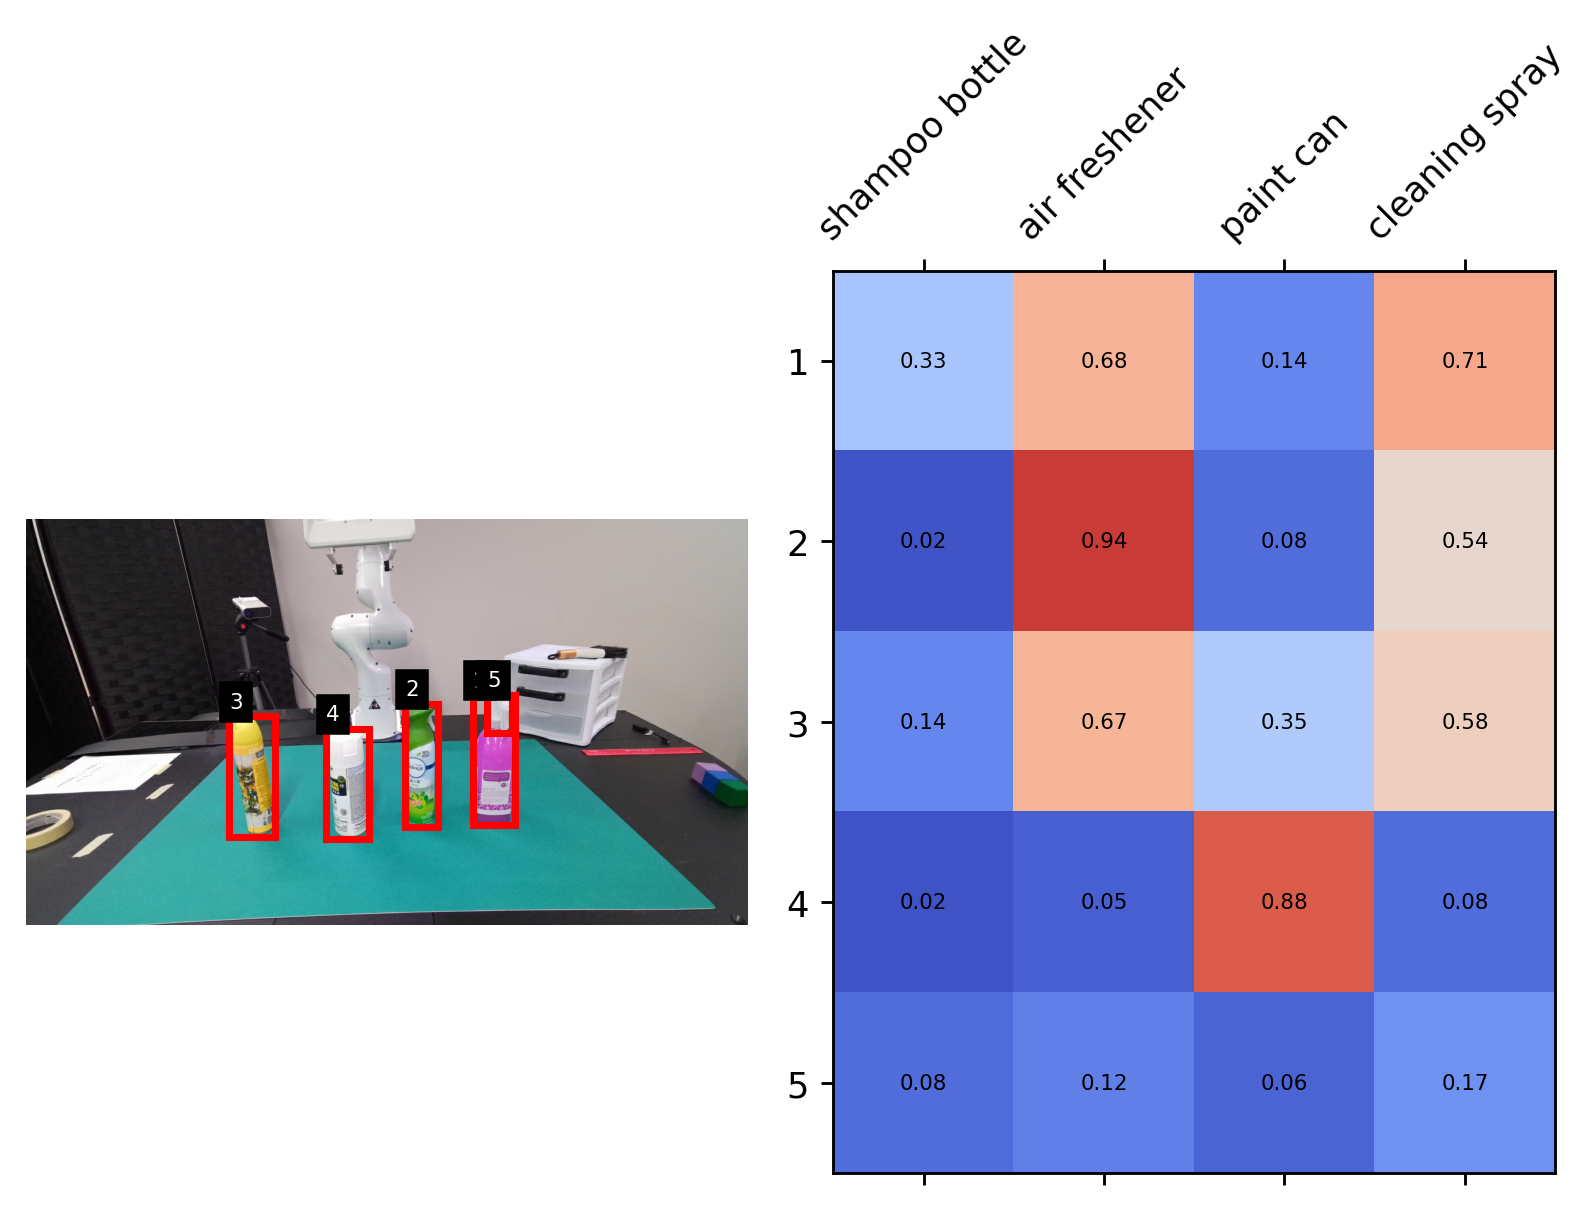

In [5]:
# Now let's try to detect something that's *not* in the image!

import numpy as np

base = '/sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/photos'

image = Image.open(os.path.join(base, 'solidbg/canisters/003_no_suave_shampoo_bottle.png'))

possible_labels = [
    'shampoo bottle',
    'air freshener',
    'paint can',
    'cleaning spray',
]

# Visualize the results.
(captions, crops, binary_logits, coarse_detection_outputs) = detect_cas.detect(image, possible_labels, verbose=True)

(boxes, scores, labels, outputs) = coarse_detection_outputs

fig = plt.figure(dpi=256)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)

for i, (x1, y1, x2, y2) in enumerate(boxes.cpu().numpy()):
    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor='r', linewidth=2
    ))
    
    text_x = x1
    text_y = max(y1 - 15, 10)

    if (x1 / image.width) > 0.9:
        text_x = x2
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'left'
        
    ax.text(
        text_x, text_y, f"{i + 1}", c='white',
        backgroundcolor=(0, 0, 0, 1.0),
        horizontalalignment=horizontalalignment,
        size=6,
    )

plt.axis('off')

ax = fig.add_subplot(1, 2, 2)
# Create a little confusion matrix.

# apply sigmoid to get scores
data = 1/(1 + np.exp(-binary_logits.detach().cpu().numpy()))

# Create a heatmap with the data
cax = ax.matshow(data, cmap='coolwarm', vmin=0, vmax=1)

# Loop over data dimensions and create text annotations.
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        text = ax.text(j, i, f"{data[i, j]:.2f}",
                       ha="center", va="center", color="black", size=6)

# Set labels for x and y axis
ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[0]))

# Optionally set axis labels
ax.set_xticklabels(possible_labels)
ax.set_yticklabels([str(i + 1) for i in range(len(captions))])
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()


In [7]:
import gc
_before = torch.cuda.memory_reserved(0)
gc.collect()
torch.cuda.empty_cache()
_after = torch.cuda.memory_reserved(0)
print(f"Saved {_before - _after} bytes of memory from cache clearance")

Saved 4519362560 bytes of memory from cache clearance


## Testing an actually-published model

Because moondream is not published, it is not really reproducible or trustworthy. I think it would be worth it to use an actually published, citable model.

I am going to use [Prismatic VLMs](https://github.com/TRI-ML/prismatic-vlms/tree/main?tab=readme-ov-file).


In [31]:
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/gsk6me/huggingface_cache'

In [35]:
import importlib
importlib.reload(prismatic_model)

05/30 [23:39:27] INFO     | >> [*] Downloading `train-2-epochs+7b     ]8;id=185814;file:///sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/env/lib/python3.11/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=321475;file:///sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/env/lib/python3.11/site-packages/prismatic/models/load.py#63\63]8;;\
                          from HF Hub                                           
05/30 [23:44:01] INFO     | >> [*] Found Config =>> Loading &         ]8;id=916800;file:///sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/env/lib/python3.11/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=379431;file:///sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/env/lib/python3.11/site-packages/prismatic/models/load.py#75\75]8;;\
                          Freezing train-2-epochs+7b with:                      
                                       Vision Backbone =>>                      
             

<module 'prismatic_model' from '/sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/compete_and_select/object_detection_evaluation/prismatic_model.py'>

In [34]:
import prismatic_model

In [41]:
prismatic_model.vlm.vision_backbone.image_transform(crops[0]).shape

torch.Size([3, 336, 336])

In [36]:
import requests
import torch

from PIL import Image
from pathlib import Path
from prismatic_model import vlm

# Download an image and specify a prompt
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
# image = crops[0]
user_prompt = "Please describe this image."

# Build prompt
prompt_builder = vlm.get_prompt_builder()
prompt_builder.add_turn(role="human", message=user_prompt)
prompt_text = prompt_builder.get_prompt()

# Generate!
with torch.no_grad():
    generated_text = vlm.generate(
        image,
        prompt_text,
        do_sample=True,
        temperature=0.4,
        max_new_tokens=512,
        min_length=1,
    )

print(generated_text)
print(prompt_text)


The image shows a dining table with various food items and drinks. There are three cups on the table, one of which contains coffee, another holds water, and the third cup is empty. A plate with beignets, a type of doughnut covered in powdered sugar, is the centerpiece of the table. 

There are also two bowls, one containing additional food, and a spoon placed near the beignets. A bottle, possibly containing a condiment, is positioned on the table as well. The table setting suggests a casual meal or gathering with friends or family.
A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Please describe this image. ASSISTANT:
